# Variational Quantum Circuit
In this notebook we work to try and use Qiskit's [VQC class](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) in order to make a circuit that can classify binary data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, GradientDescent, P_BFGS, QNSPSA, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import statistics

algorithm_globals.random_seed = 0
np.random.seed(0)

## Importing the data
In this notebook, we will use the following datasets:
 - [diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) which is a dataset containing 9 numeric features and a binary class
 - [iris dataset](https://www.kaggle.com/datasets/uciml/iris) which is a dataset containing 5 numeric features and 3 classes
 - [banknote dataset](https://machinelearningmastery.com/standard-machine-learning-datasets/) which is a dataset containing 4 numeric featues and a binary class

In [2]:
# Import the diabetes data
data = np.loadtxt('../datasets/diabetes.csv', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_diabetes, sample_test_diabetes, label_train_diabetes, label_test_diabetes = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_diabetes = normalize(sample_train_diabetes)
sample_test_diabetes = normalize(sample_test_diabetes)

In [3]:
# Import the iris data
data = np.loadtxt('../datasets/iris_data_numeric.txt', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_iris, sample_test_iris, label_train_iris, label_test_iris = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_iris = normalize(sample_train_iris)
sample_test_iris = normalize(sample_test_iris)

In [4]:
# Import the banknote data
data = np.loadtxt('../datasets/data_banknote_authentication.txt', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Only train on the 100 samples to start to speed up training
train_size = min(1, 100/n)

# Split data into training set and testing set
sample_train_banknote, sample_test_banknote, label_train_banknote, label_test_banknote = train_test_split(x, y,shuffle=True, train_size=train_size) 

# Normalize the data
sample_train_banknote = normalize(sample_train_banknote)
sample_test_banknote = normalize(sample_test_banknote)

## Creating artificial data
In addition to the real world data we have, we will also create 2 simple artificial data sets that will hopefully be easier to classify as a proof on concept.

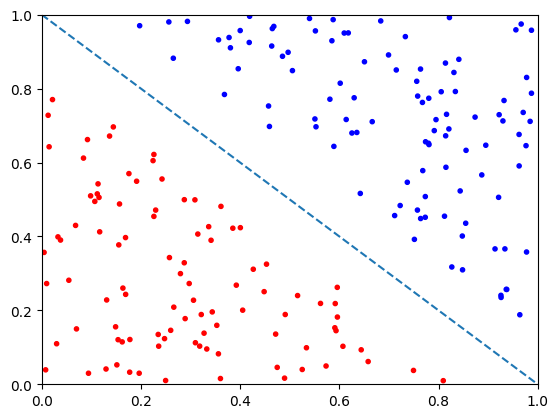

In [5]:
# Create a simple linear test dataset
num_train = 200
num_test = 100
lower_bound = 0
upper_bound = 1
min_dist = 0.1

# Define the function that determines the class
def f_linear(x):
    return -1*x + 1

def distance_to_line(x, y):
    return abs(x + y - 1)/np.sqrt(2)

def class_linear(x, y):
    if (y < f_linear(x)):
        return 0
    else:
        return 1

# Create the training and test set
sample_train_linear = np.random.rand(num_train, 2) * (upper_bound - lower_bound) + lower_bound
sample_test_linear = np.random.rand(num_test, 2) * (upper_bound - lower_bound) + lower_bound
label_train_linear = np.zeros(num_train)
label_test_linear = np.zeros(num_test)

# Force the training data to be a certain distance from the decision boundary
for i, point in enumerate(sample_train_linear):
    x = point[0]
    y = point[1]
    while (distance_to_line(x, y) < min_dist):
        x = np.random.rand()
        y = np.random.rand()
    sample_train_linear[i] = [x, y]

for i, point in enumerate(sample_test_linear):
    x = point[0]
    y = point[1]
    while (distance_to_line(x, y) < min_dist):
        x = np.random.rand()
        y = np.random.rand()
    sample_test_linear[i] = [x, y]

for i, x in enumerate(sample_train_linear):
    label_train_linear[i] = class_linear(x[0], x[1])

for i, x in enumerate(sample_test_linear):
    label_test_linear[i] = class_linear(x[0], x[1])

# Plot the dataset
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in label_train_linear]
plt.scatter(sample_train_linear[:,0], sample_train_linear[:,1], color=color, marker='.')

# Plot the decision boundary
x = np.linspace(lower_bound, upper_bound, 100)
y = f_linear(x)
plt.plot(x, y, '--')

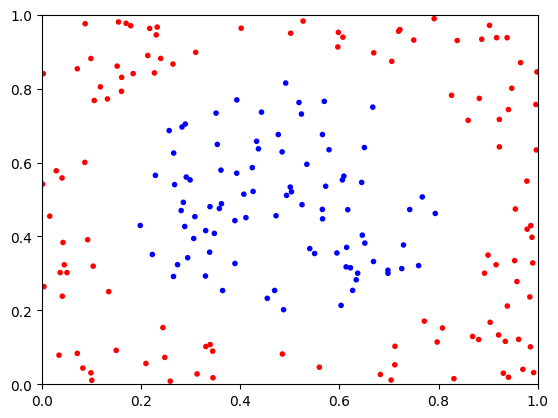

In [6]:
# Create a simple non-linear test dataset
num_train = 200
num_test = 100
lower_bound = 0
upper_bound = 1
data_radius = 0.1
boundary_width = 0.075

# Define the function that determines the class
def f_nonlinear(x, y):
    return (x-0.5)**2 + (y-0.5)**2

def class_nonlinear(x, y):
    if (f_nonlinear(x, y) > data_radius):
        return 0
    else:
        return 1

# Create the training and test set
sample_train_nonlinear = np.random.rand(num_train, 2) * (upper_bound - lower_bound) + lower_bound
sample_test_nonlinear = np.random.rand(num_test, 2) * (upper_bound - lower_bound) + lower_bound
label_train_nonlinear = np.zeros(num_train)
label_test_nonlinear = np.zeros(num_test)

# Create a gap between the train and test sets
for i, point in enumerate(sample_train_nonlinear):
    x = point[0]
    y = point[1]
    while(f_nonlinear(x, y) > data_radius and f_nonlinear(x, y) < data_radius + boundary_width):
        x = np.random.rand()
        y = np.random.rand()
    sample_train_nonlinear[i] = [x, y]

for i, point in enumerate(sample_test_nonlinear):
    x = point[0]
    y = point[1]
    while(f_nonlinear(x, y) > data_radius and f_nonlinear(x, y) < data_radius + boundary_width):
        x = np.random.rand()
        y = np.random.rand()
    sample_test_nonlinear[i] = [x, y]

# Create the labels as one hot encoded arrays
for i, x in enumerate(sample_train_nonlinear):
    label_train_nonlinear[i] = class_nonlinear(x[0], x[1])
for i, x in enumerate(sample_test_nonlinear):
    label_test_nonlinear[i] = class_nonlinear(x[0], x[1])

# Plot the dataset
plt.ylim(lower_bound, upper_bound)
plt.xlim(lower_bound, upper_bound)
color= ['red' if l == 0 else 'blue' for l in label_train_nonlinear]
plt.scatter(sample_train_nonlinear[:,0], sample_train_nonlinear[:,1], color=color, marker='.')

## Create the Variational Circuit
For our inital circuit, we will use cnot gates as out entangling layer, and we will start with just rz gates. We will have a cnot gate connect between every adjacent gate similar to one of the examples of entangling layers given in [this paper](https://arxiv.org/abs/2206.02806)

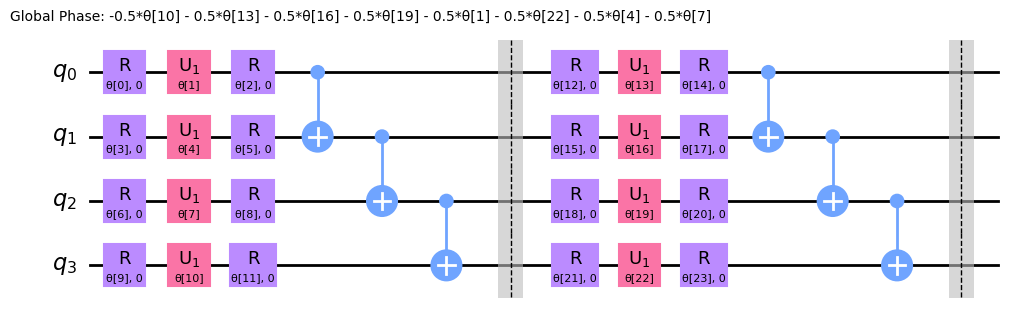

In [7]:
# Create a function so we can easily create new circuits
def cnot_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cx(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cnot_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')

## Train on Linear Dataset
Here we actually train the circuit. To start we will just use the ZZfeature map and the [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html) optimizer (Constrained Optimization By Linear Approximation opimizer). We can later vary these to see how they impact the training. 

### Classical model
We will train a classical neural network on the dataset initially so that we can later compare the performance to the quantum system

In [8]:
# train model and use it to make prediction
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, learning_rate_init=0.01)
model.fit(sample_train_linear, label_train_linear)
label_train_pred = model.predict(sample_train_linear)
label_test_pred = model.predict(sample_test_linear)

# evaluate model error
error_train = 1 - accuracy_score(label_train_linear, label_train_pred)
error_test = 1 - accuracy_score(label_test_linear, label_test_pred)

# print results
print("Training Error = %.4f" % error_train)
print('Testing Error = %.4f' % error_test)

Training Error = 0.0000
Testing Error = 0.0000


### Train and vary number of layers

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

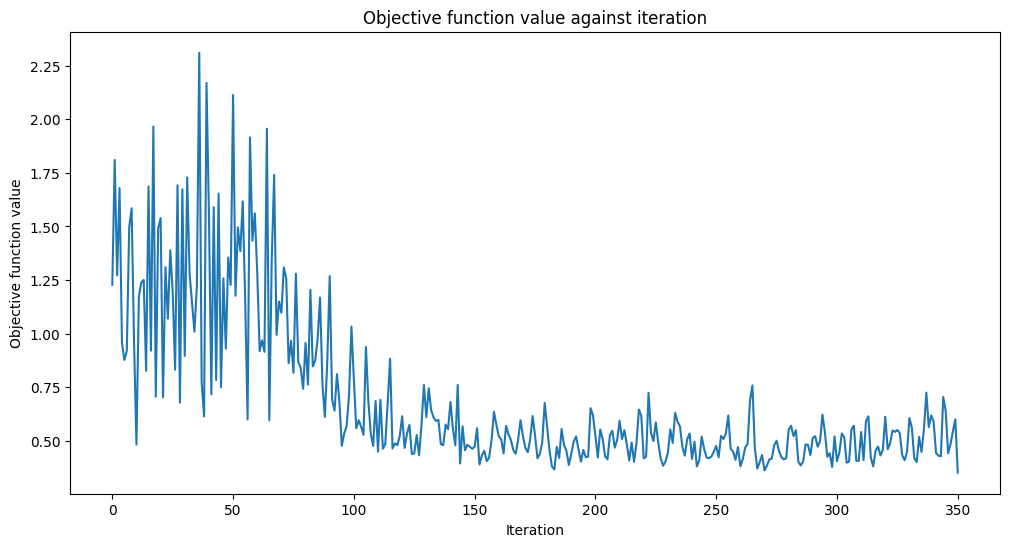

In [10]:
# Vary the number of layers
num_layers_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
layer_train_accuracy = []
layer_test_accuracy = []
for num_layers in num_layers_to_test:
    # Use 3-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    X = sample_train_linear
    y = label_train_linear
    kf = KFold(n_splits=3)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
        num_inputs = len(X_train[0])
        
        # construct feature map, ansatz, and optimizer
        feature_map = ZZFeatureMap(num_inputs)
        ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
        initial_point = np.random.rand(3*num_inputs*num_layers)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=150),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(X_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(X_train, y_train)
        testing_error = 1 - vqc.score(X_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the 3 folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [11]:
#Save the training results to a dataframe
data = {'Layers': num_layers_to_test,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

linear_data = pd.DataFrame(data)
linear_data.to_pickle('linear_vary_layers.pkl')

linear_data

,Layers,Training Error,Testing Error
0,1,0.155014,0.160033
1,2,0.110033,0.114956
2,3,0.070045,0.085029
3,4,0.067389,0.090080
4,5,0.089945,0.070029
5,6,0.069970,0.084879
6,7,0.054988,0.090005
7,8,0.082445,0.084954
8,9,0.060001,0.079904
9,10,0.079957,0.110131


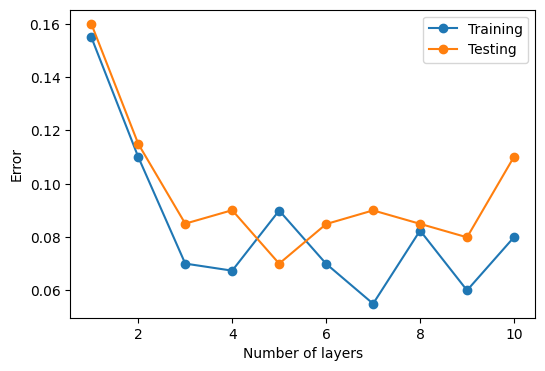

In [12]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(linear_data['Layers'], linear_data['Training Error'], marker='o', label="Training")
ax.plot(linear_data['Layers'], linear_data['Testing Error'], marker='o', label="Testing")
ax.legend()

## Train on Iris Data

### Classical Model

In [13]:
# train model and use it to make prediction
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, learning_rate_init=0.01)
model.fit(sample_train_iris, label_train_iris)
label_train_pred = model.predict(sample_train_iris)
label_test_pred = model.predict(sample_test_iris)

# evaluate model error
error_train = 1 - accuracy_score(label_train_iris, label_train_pred)
error_test = 1 - accuracy_score(label_test_iris, label_test_pred)

# print results
print("Training Error = %.4f" % error_train)
print('Testing Error = %.4f' % error_test)

Training Error = 0.0500
Testing Error = 0.0204


## Train and vary number of layers

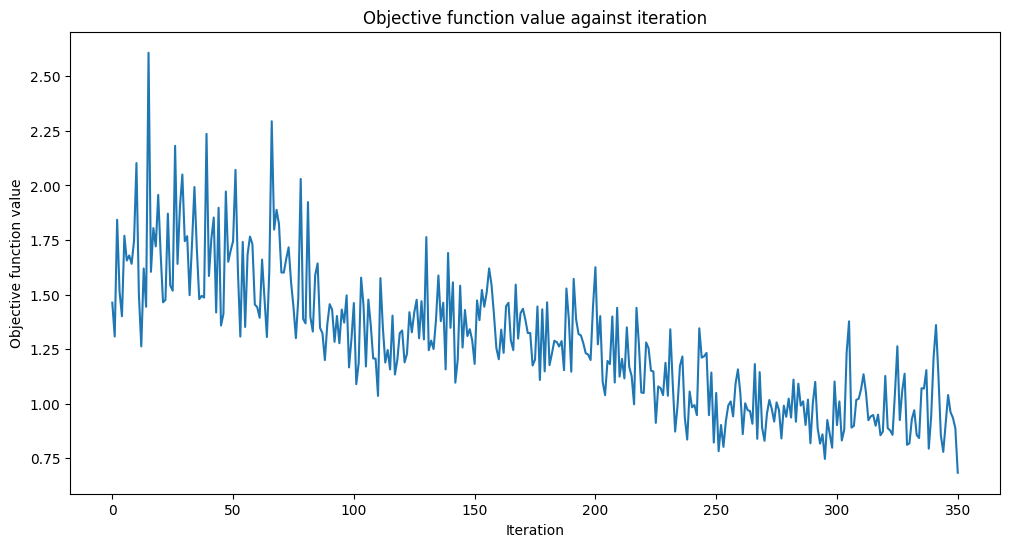

In [14]:
# Vary the number of layers
num_layers_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
layer_train_accuracy = []
layer_test_accuracy = []
for num_layers in num_layers_to_test:
    # Use 3-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    X = sample_train_iris
    y = label_train_iris
    kf = KFold(n_splits=3)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
        num_inputs = len(X_train[0])
        
        # construct feature map, ansatz, and optimizer
        feature_map = ZZFeatureMap(num_inputs)
        ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
        initial_point = np.random.rand(3*num_inputs*num_layers)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=150),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(X_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(X_train, y_train)
        testing_error = 1 - vqc.score(X_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the 3 folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [15]:
#Save the training results to a dataframe
data = {'Layers': num_layers_to_test,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

iris_data = pd.DataFrame(data)
iris_data.to_pickle('iris_vary_layers.pkl')

iris_data

,Layers,Training Error,Testing Error
0,1,0.070029,0.070113
1,2,0.060003,0.050208
2,3,0.069878,0.069519
3,4,0.060078,0.039810
4,5,0.064978,0.019905
5,6,0.029926,0.069519
6,7,0.055028,0.039513
7,8,0.080130,0.109626
8,9,0.109754,0.100119
9,10,0.054953,0.060012


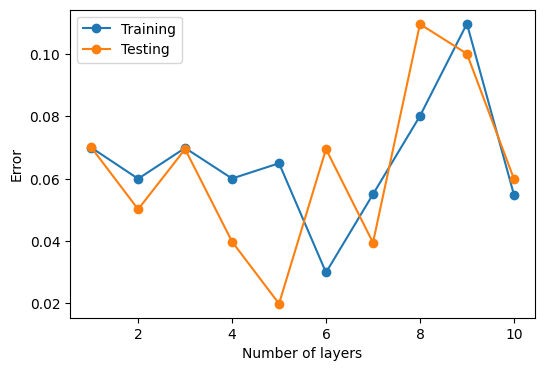

In [16]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(iris_data['Layers'], iris_data['Training Error'], marker='o', label="Training")
ax.plot(iris_data['Layers'], iris_data['Testing Error'], marker='o', label="Testing")
ax.legend()

## Train on Nonlinear Data

### Classical Model

In [17]:
# train model and use it to make prediction
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, learning_rate_init=0.01)
model.fit(sample_train_nonlinear, label_train_nonlinear)
label_train_pred = model.predict(sample_train_nonlinear)
label_test_pred = model.predict(sample_test_nonlinear)

# evaluate model error
error_train = 1 - accuracy_score(label_train_nonlinear, label_train_pred)
error_test = 1 - accuracy_score(label_test_nonlinear, label_test_pred)

# print results
print("Training Error = %.4f" % error_train)
print('Testing Error = %.4f' % error_test)

Training Error = 0.0000
Testing Error = 0.0000


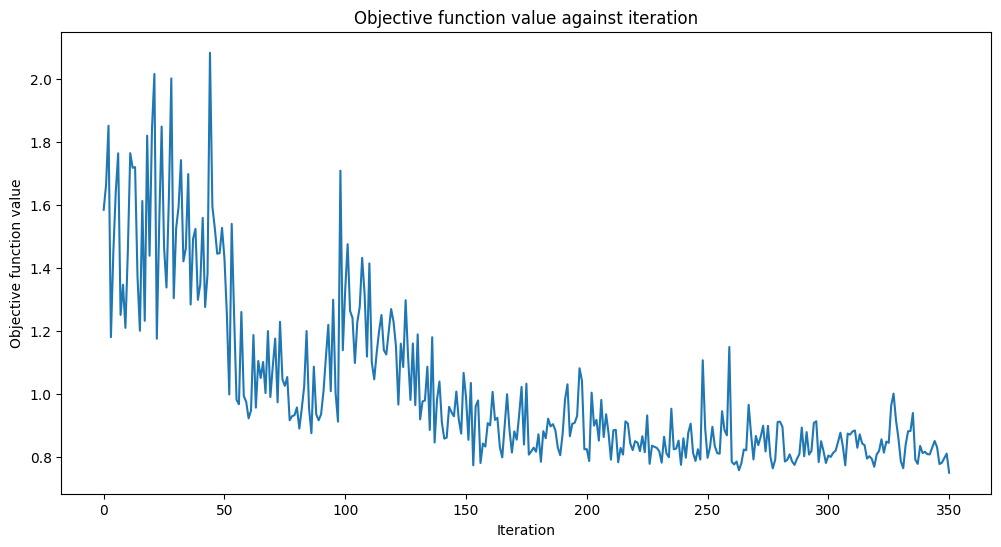

In [18]:
# Vary the number of layers
num_layers_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
layer_train_accuracy = []
layer_test_accuracy = []
for num_layers in num_layers_to_test:
    # Use 3-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    X = sample_train_nonlinear
    y = label_train_nonlinear
    kf = KFold(n_splits=3)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
        num_inputs = len(X_train[0])
        
        # construct feature map, ansatz, and optimizer
        feature_map = ZZFeatureMap(num_inputs)
        ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
        initial_point = np.random.rand(3*num_inputs*num_layers)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=150),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(X_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(X_train, y_train)
        testing_error = 1 - vqc.score(X_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the 3 folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [19]:
#Save the training results to a dataframe
data = {'Layers': num_layers_to_test,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

nonlinear_data = pd.DataFrame(data)
nonlinear_data.to_pickle('nonlinear_vary_layers.pkl')

nonlinear_data

,Layers,Training Error,Testing Error
0,1,0.407380,0.439771
1,2,0.267497,0.259837
2,3,0.234990,0.265189
3,4,0.239966,0.245138
4,5,0.237515,0.239937
5,6,0.210003,0.250113
6,7,0.222478,0.205035
7,8,0.214978,0.229986
8,9,0.224947,0.230213
9,10,0.219990,0.239861


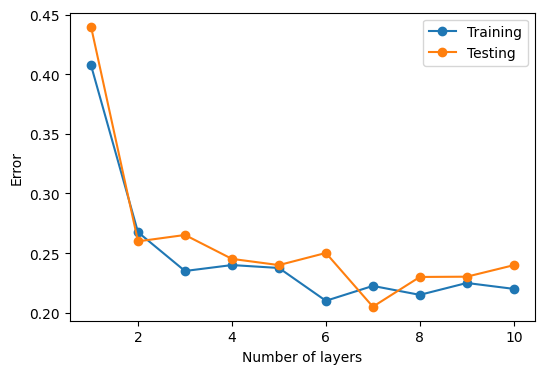

In [20]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(nonlinear_data['Layers'], nonlinear_data['Training Error'], marker='o', label="Training")
ax.plot(nonlinear_data['Layers'], nonlinear_data['Testing Error'], marker='o', label="Testing")
ax.legend()

## Try CZ entanglement layer
This time instead of CNOT gates, we will use CZ gates for the entanglement layer and then run the same set of tests to see how that impacts performance

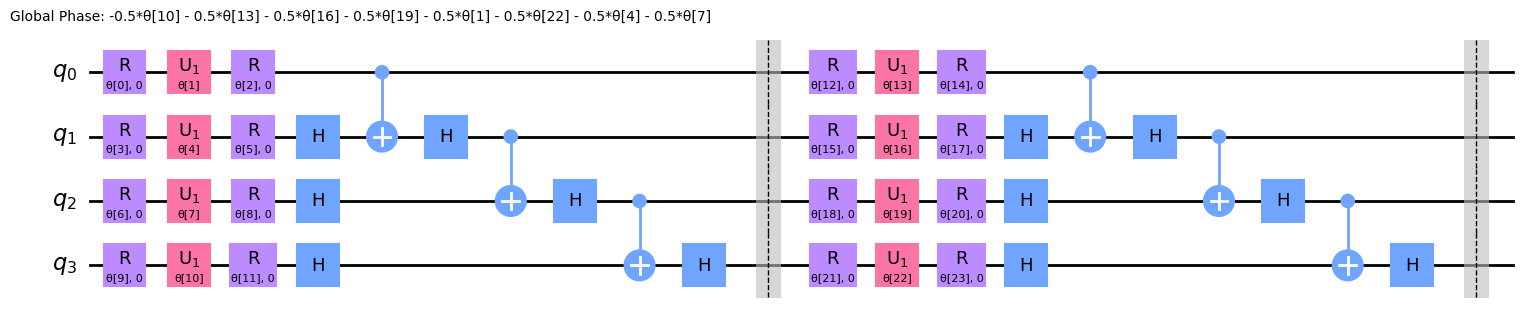

In [21]:
# Create a function so we can easily create new circuits
def cz_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cz(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cz_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')